<a href="https://www.kaggle.com/code/patrickstarrrr/deep-feedforward-networks-mlp-taxi-fare-predict?scriptVersionId=137719089" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div align="center"> Hi, everyone! When writing this code, I was guided by the book "Neural Network Projects with Python" by James Loy.</div>

<div align="center">The dataset that we will be using for this project is the New York Taxi Fare dataset. The original data set contains a 55 million travel records from 2009 to 2015, including data such as number of passengers, drop-off and pick-up locations and pick-up times. We will not be importing the original 55M row dataset, instead, for optimal running and learning speed, we will import the first 10% of the sample to develop our algorithm and work only with the train.csv set.</div>

In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv',parse_dates=['pickup_datetime'], nrows=5500000)

Сonsider the first few rows of our dataset:

In [2]:
df.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

We see the columns of our dataset:

1. coordinates of pickup/dropoff:
     **'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'**
    
2. columns with the same meaning date and time:
     **'pickup_datetime', 'key'** - we can drop **'key'** column without any loss of information
    
3. the cost of travel - **'fare_amount'**

4. number of passengers on the trip - **'passenger_count'**

In [3]:
df = df.drop(['key'], axis=1)

Let's check the data for outliers right away. In such a large dataset, there are bound to be outliers that could skew our model:

In [4]:
df.describe().applymap(lambda x: f"{x:0.3f}")

fare_amount pickup_longitude pickup_latitude dropoff_longitude  \
count  5500000.000      5500000.000     5500000.000       5499964.000   
mean        11.342          -72.510          39.922           -72.509   
std          9.819           12.812           9.024            12.832   
min       -100.000        -3426.609       -3488.080         -3412.653   
25%          6.000          -73.992          40.735           -73.991   
50%          8.500          -73.982          40.753           -73.980   
75%         12.500          -73.967          40.767           -73.964   
max       1273.310         3439.426        3344.459          3457.622   

      dropoff_latitude passenger_count  
count      5499964.000     5500000.000  
mean            39.918           1.685  
std              9.250           1.330  
min          -3488.080           0.000  
25%             40.734           1.000  
50%             40.753           1.000  
75%             40.768           2.000  
max           3345.917         208.000

We see the presence of strange values in the **max and min coordinates, the max count of passengers and the cost of the trip**.
Let's look at each of them.

#### Coordinates

The valid range of latitude in degrees is **-90** and **+90** for the southern and northern hemisphere, respectively. Longitude is in the range **-180** and **+180** specifying coordinates west and east of the Prime Meridian, respectively. But we see Max and Min latitude and longitude in our data set near ±3000 - it's definitely a mistake. Let's plot a scatterplot of pickup's points:

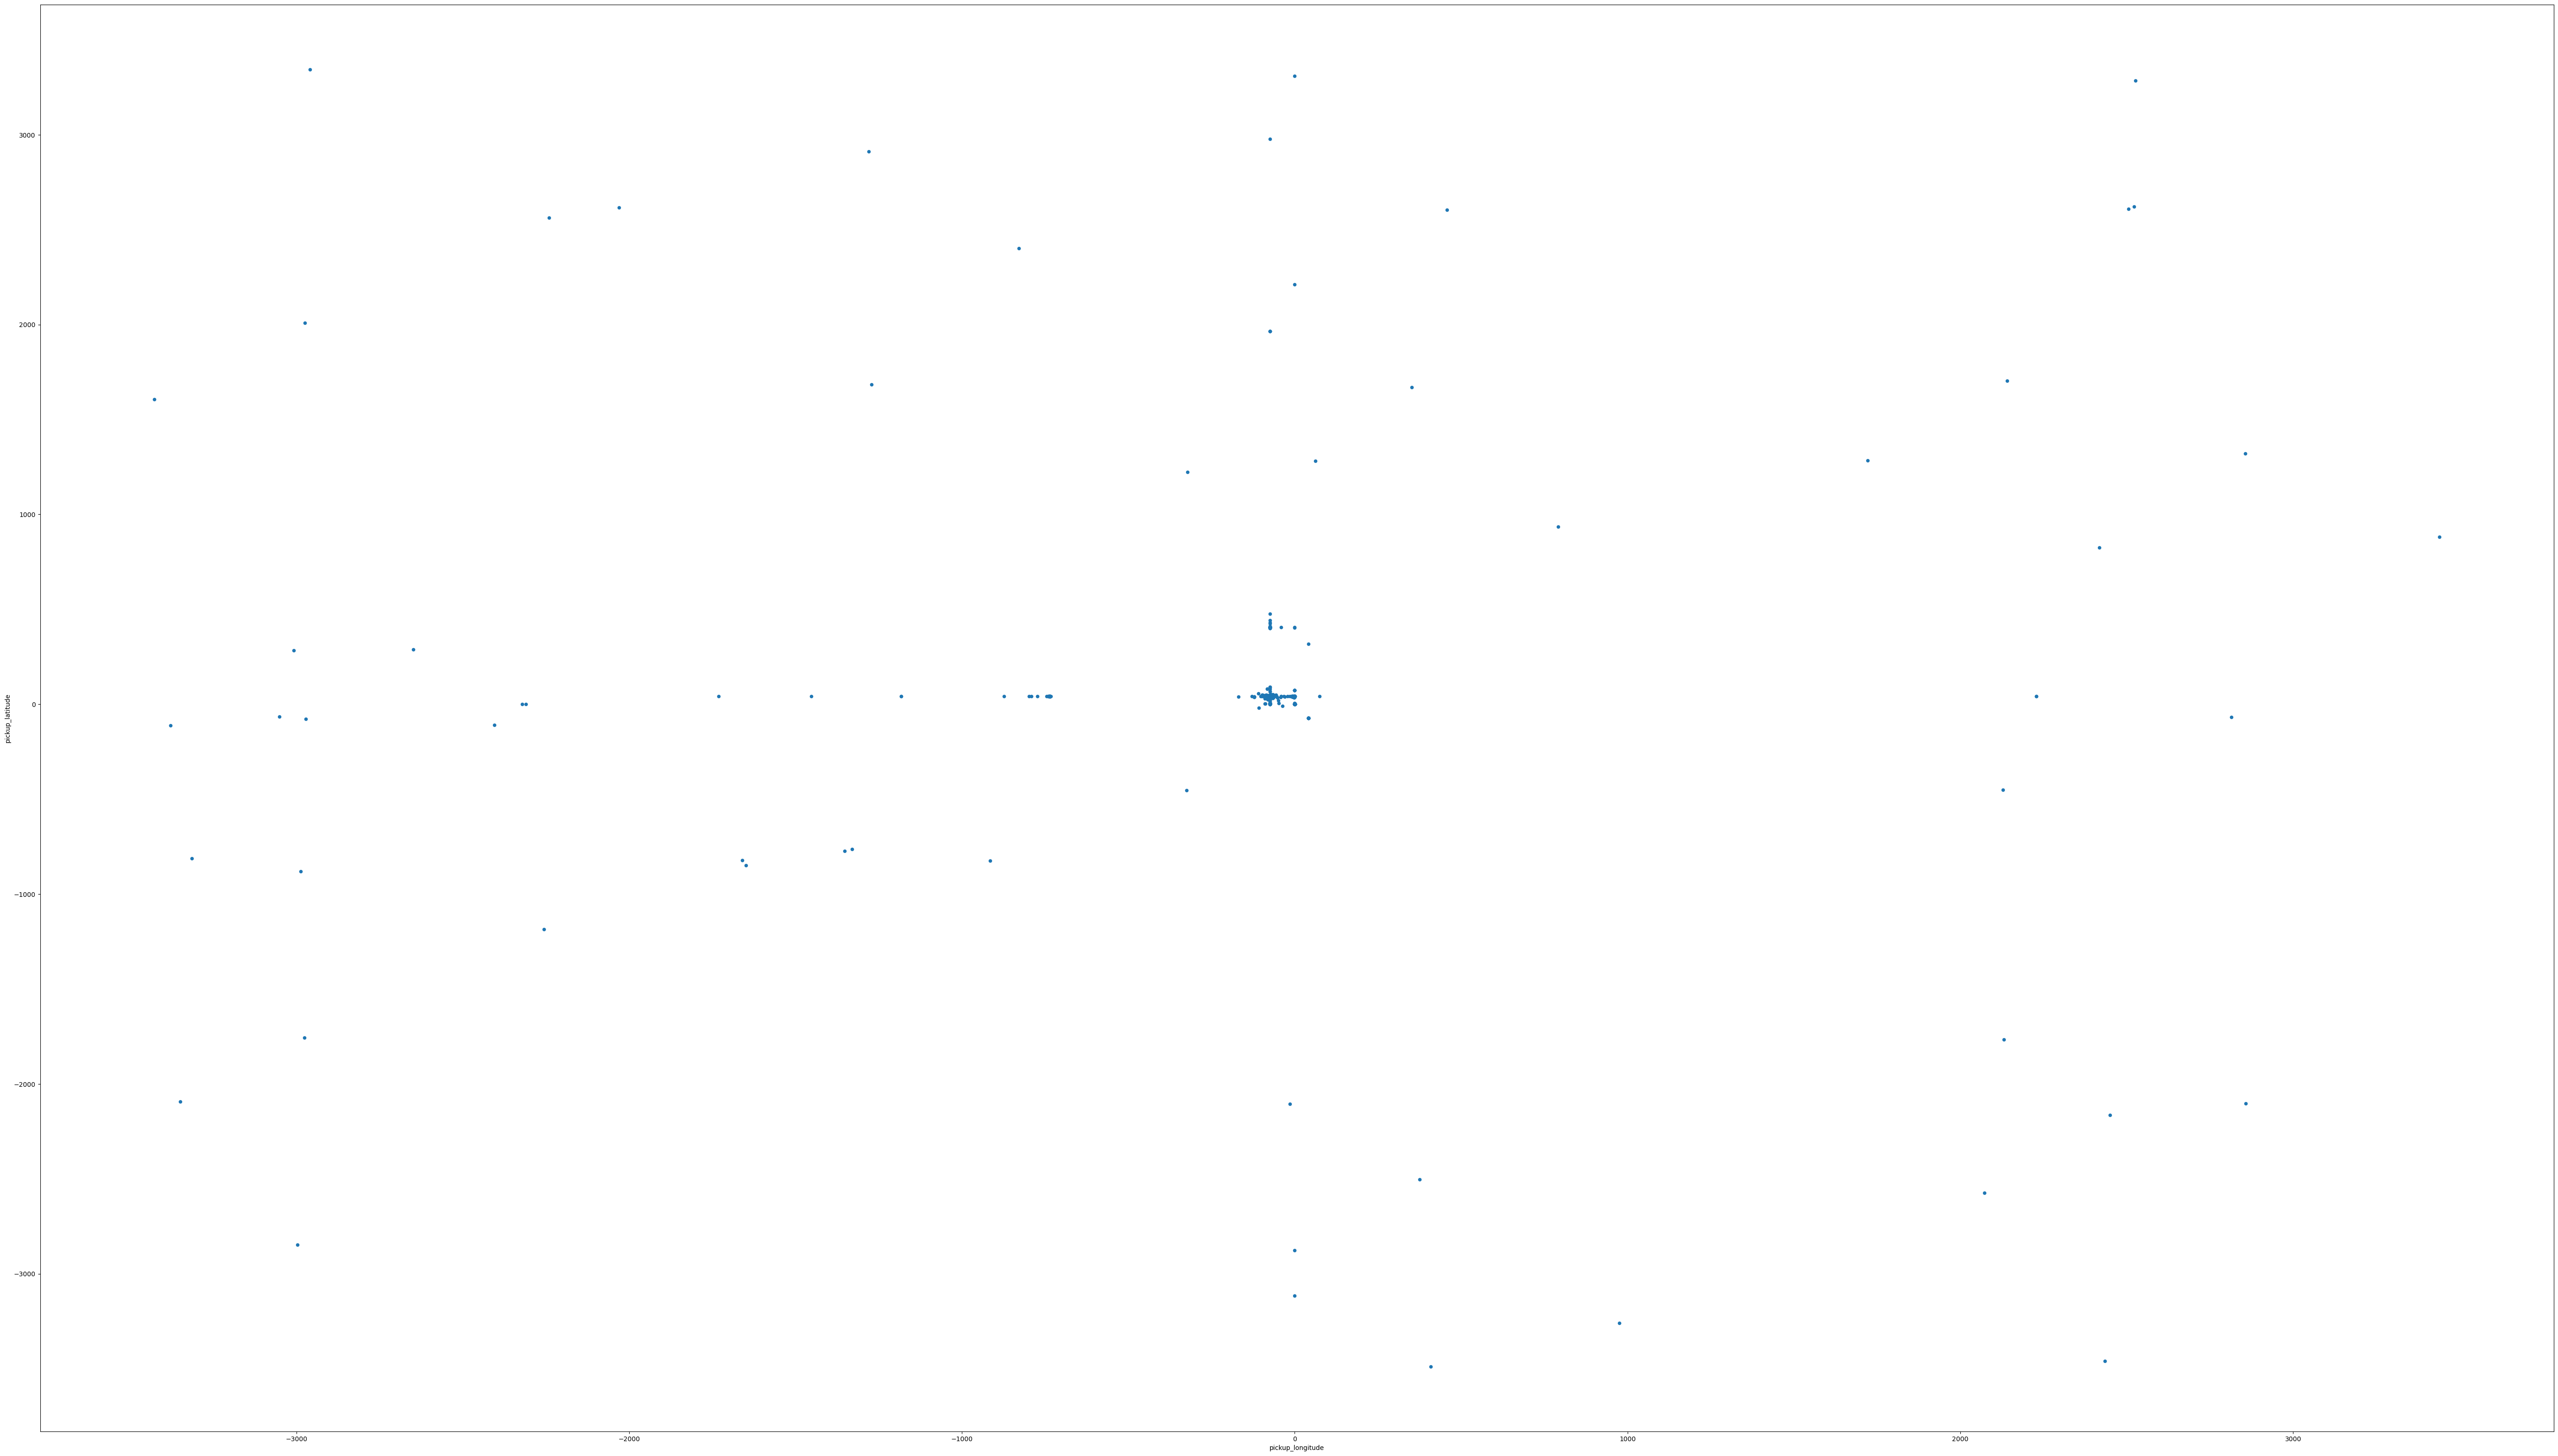

In [5]:
import matplotlib.pyplot as plt

df.plot.scatter('pickup_longitude', 'pickup_latitude',figsize=(70, 40))
plt.show()

Now we restrict our coordinates to the approximate boundaries of New York and that part of New Jersey where the international airport is located Newark Liberty:

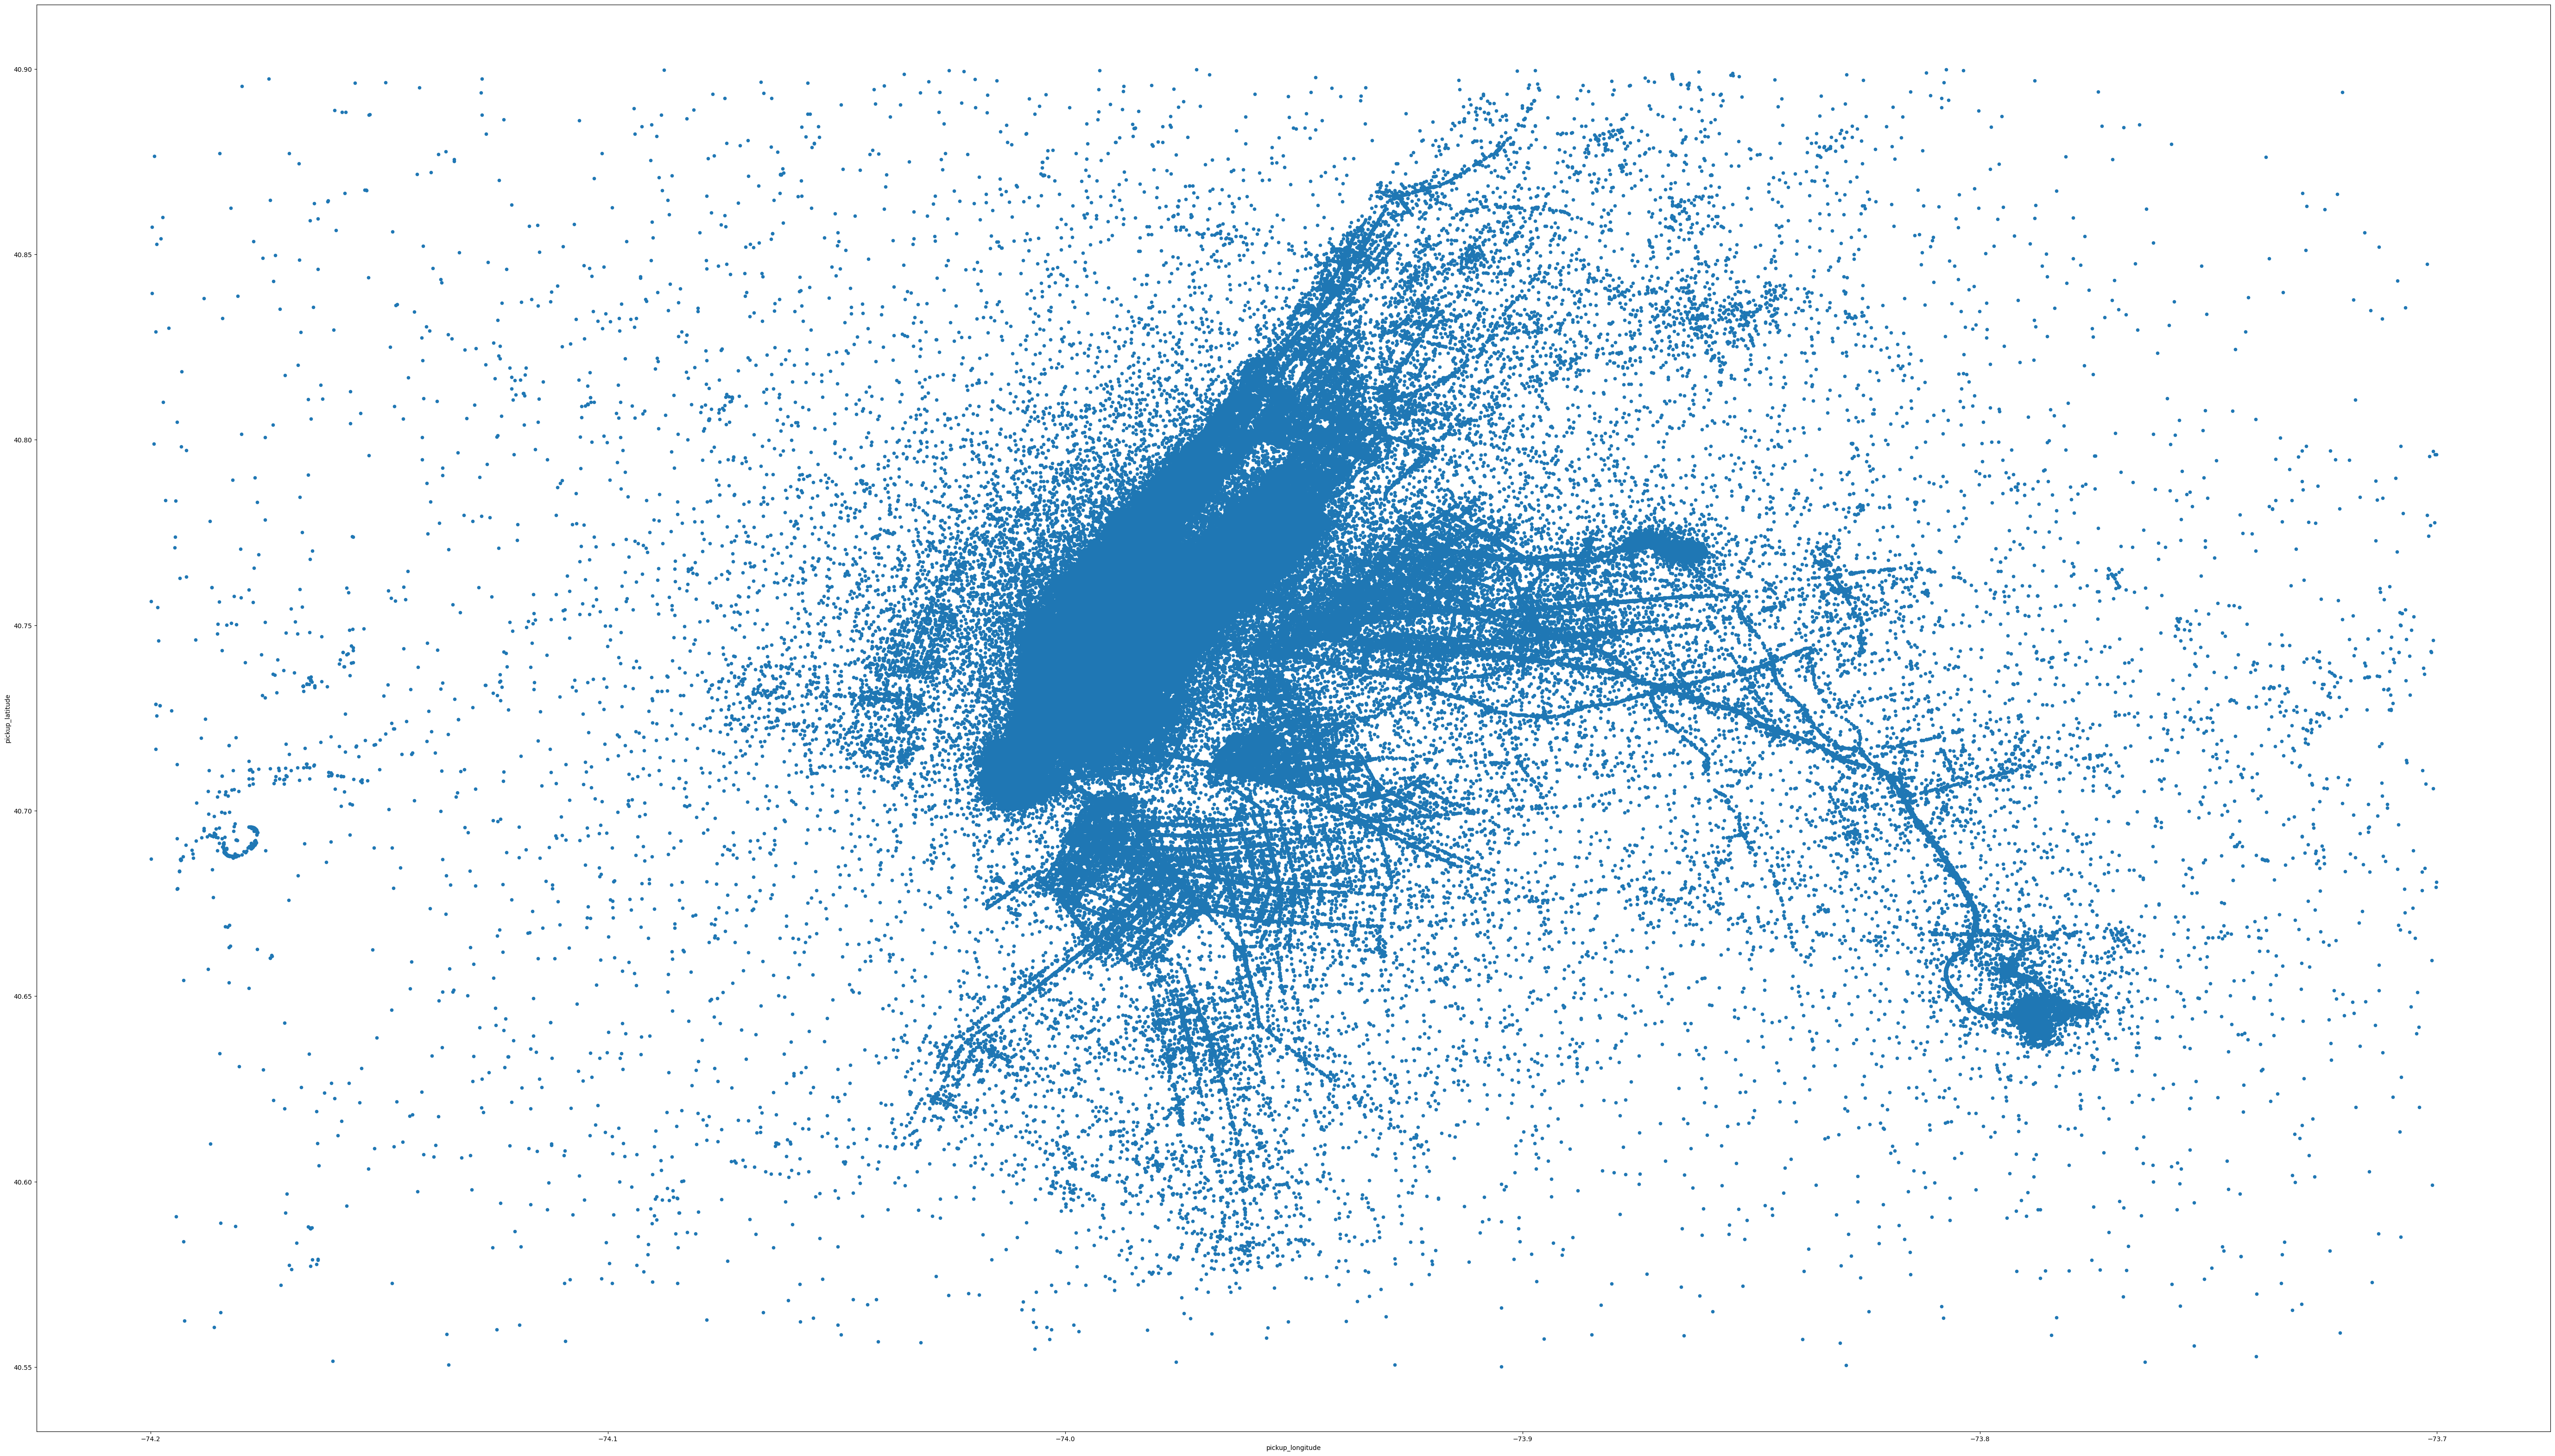

In [6]:
# longitude for NYC and part of NJ
min_longitude = -74.2
max_longitude = -73.7

# latitude for NYC and part of NJ
min_latitude = 40.55
max_latitude = 40.9

# only consider locations within NYC and part of NJ
for longitude in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[longitude] > min_longitude) & (df[longitude] < max_longitude)]

for latitude in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[latitude] > min_latitude) & (df[latitude] < max_latitude)]
    
df.plot.scatter('pickup_longitude', 'pickup_latitude',figsize=(70, 40))
plt.show()

Awesome! Quite another matter. We even see the recognizable features of New York.\
Let's mark the main attractions on our map:

In [7]:
landmarks = {'Times Square': (-73.985, 40.758),
             'JFK Airport': (-73.78, 40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Newark Airport (EWR)': (-74.17, 40.69),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66),
             'Mid Island':(-74.14,40.61),
             'Queens':(-73.87,40.75),
             'Coney Island':(-73.99,40.57)}

We will see the following scatterplot showing the **pickup** locations:

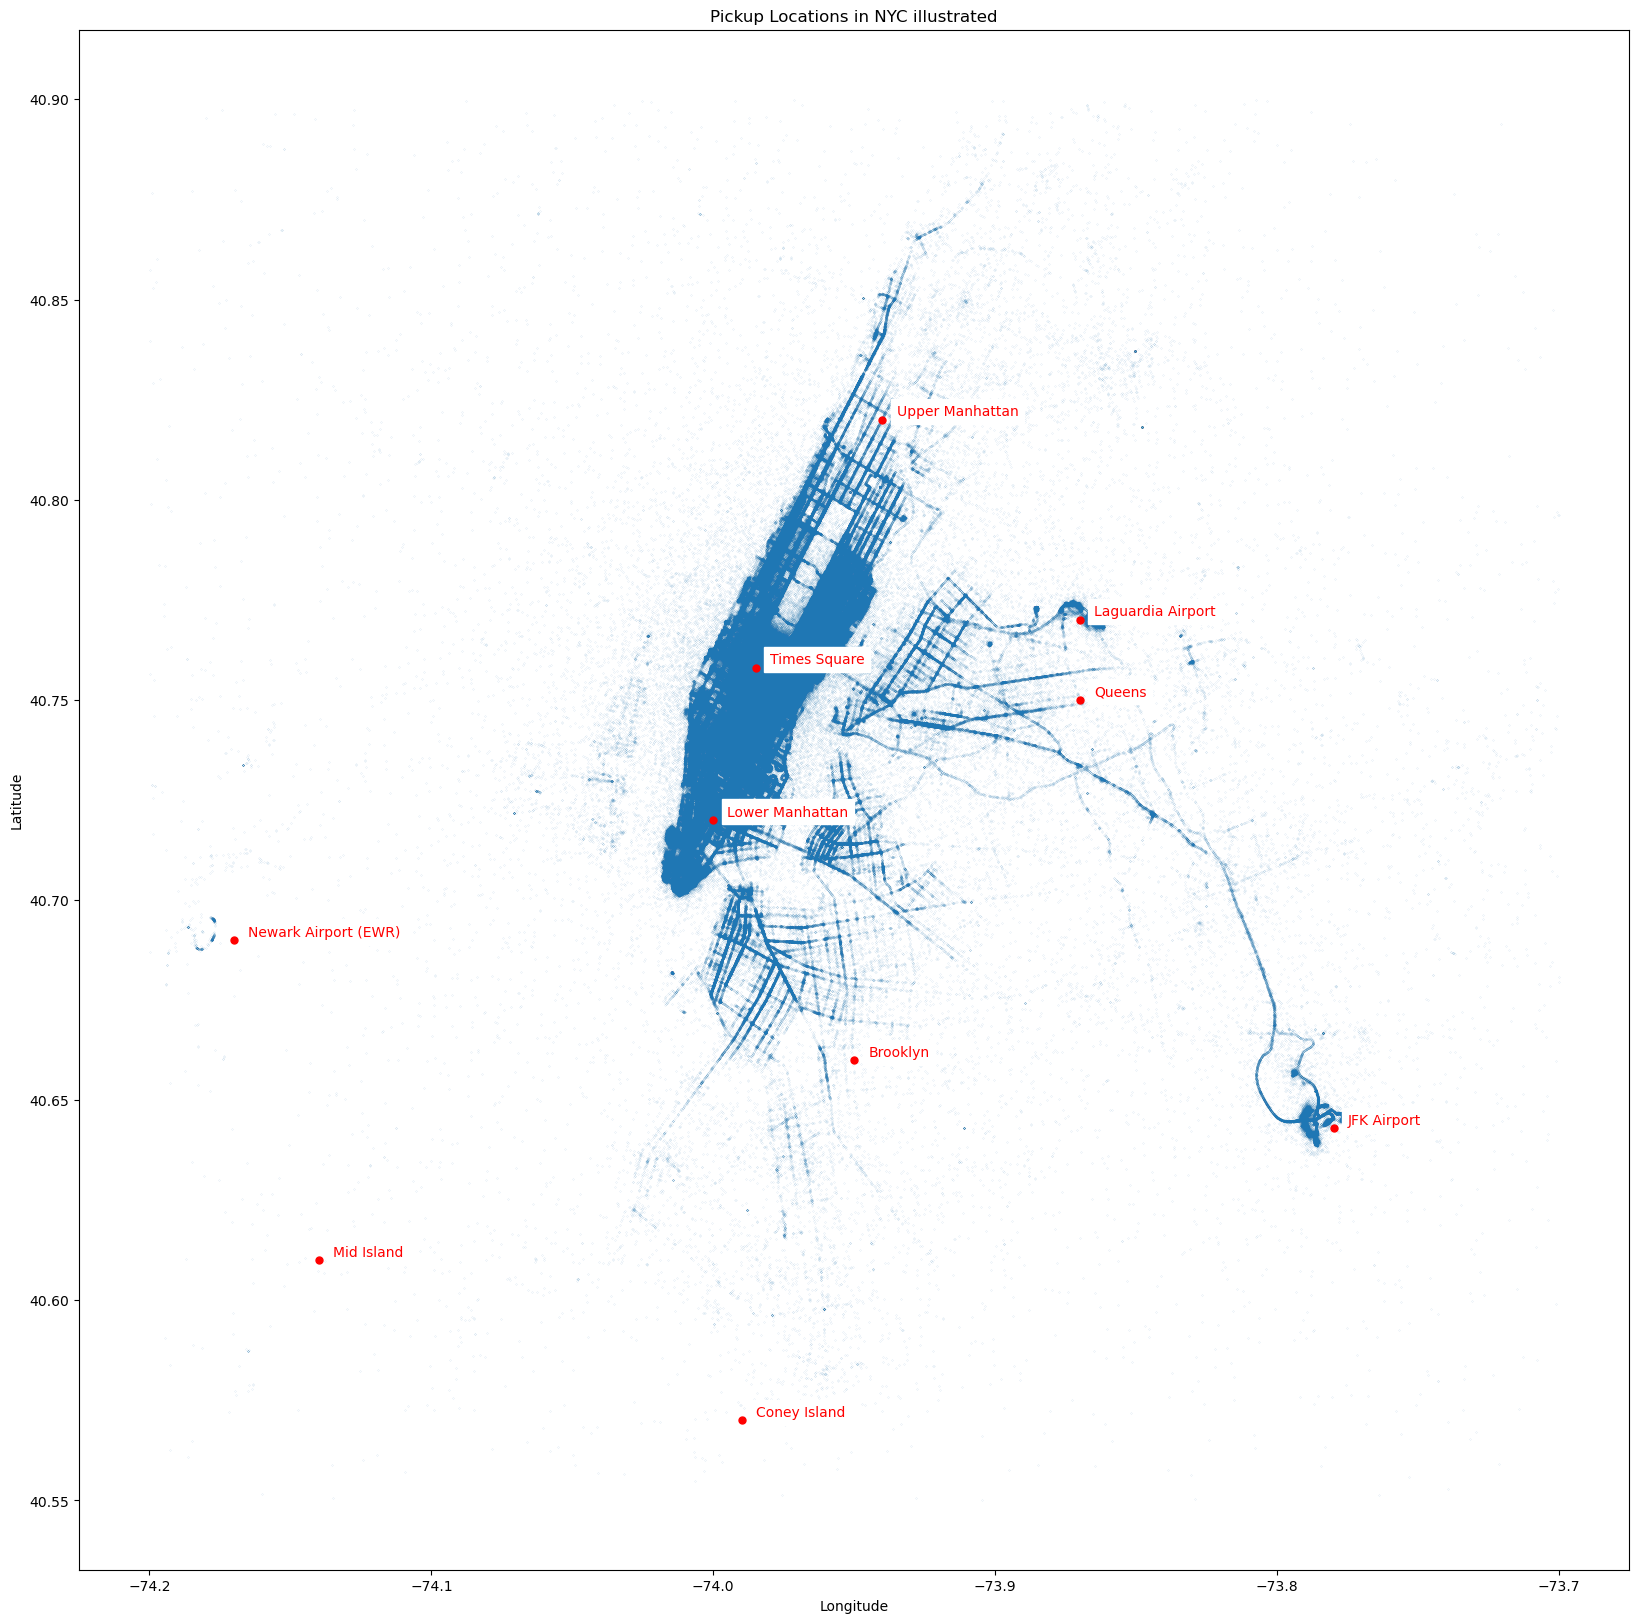

In [8]:
plt.figure(figsize = (20,20))
plt.plot(list(df.pickup_longitude), list(df.pickup_latitude),'.', markersize=0.1)

for landmark in landmarks:
    plt.plot(landmarks[landmark][0], landmarks[landmark][1],'.', markersize=10, alpha=1, color='r') 
    plt.annotate(landmark, (landmarks[landmark][0]+0.005, landmarks[landmark][1]+0.001), color='r', backgroundcolor='w')

plt.title("Pickup Locations in NYC illustrated")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Now we will see the following scatterplot showing the **dropoff** locations:

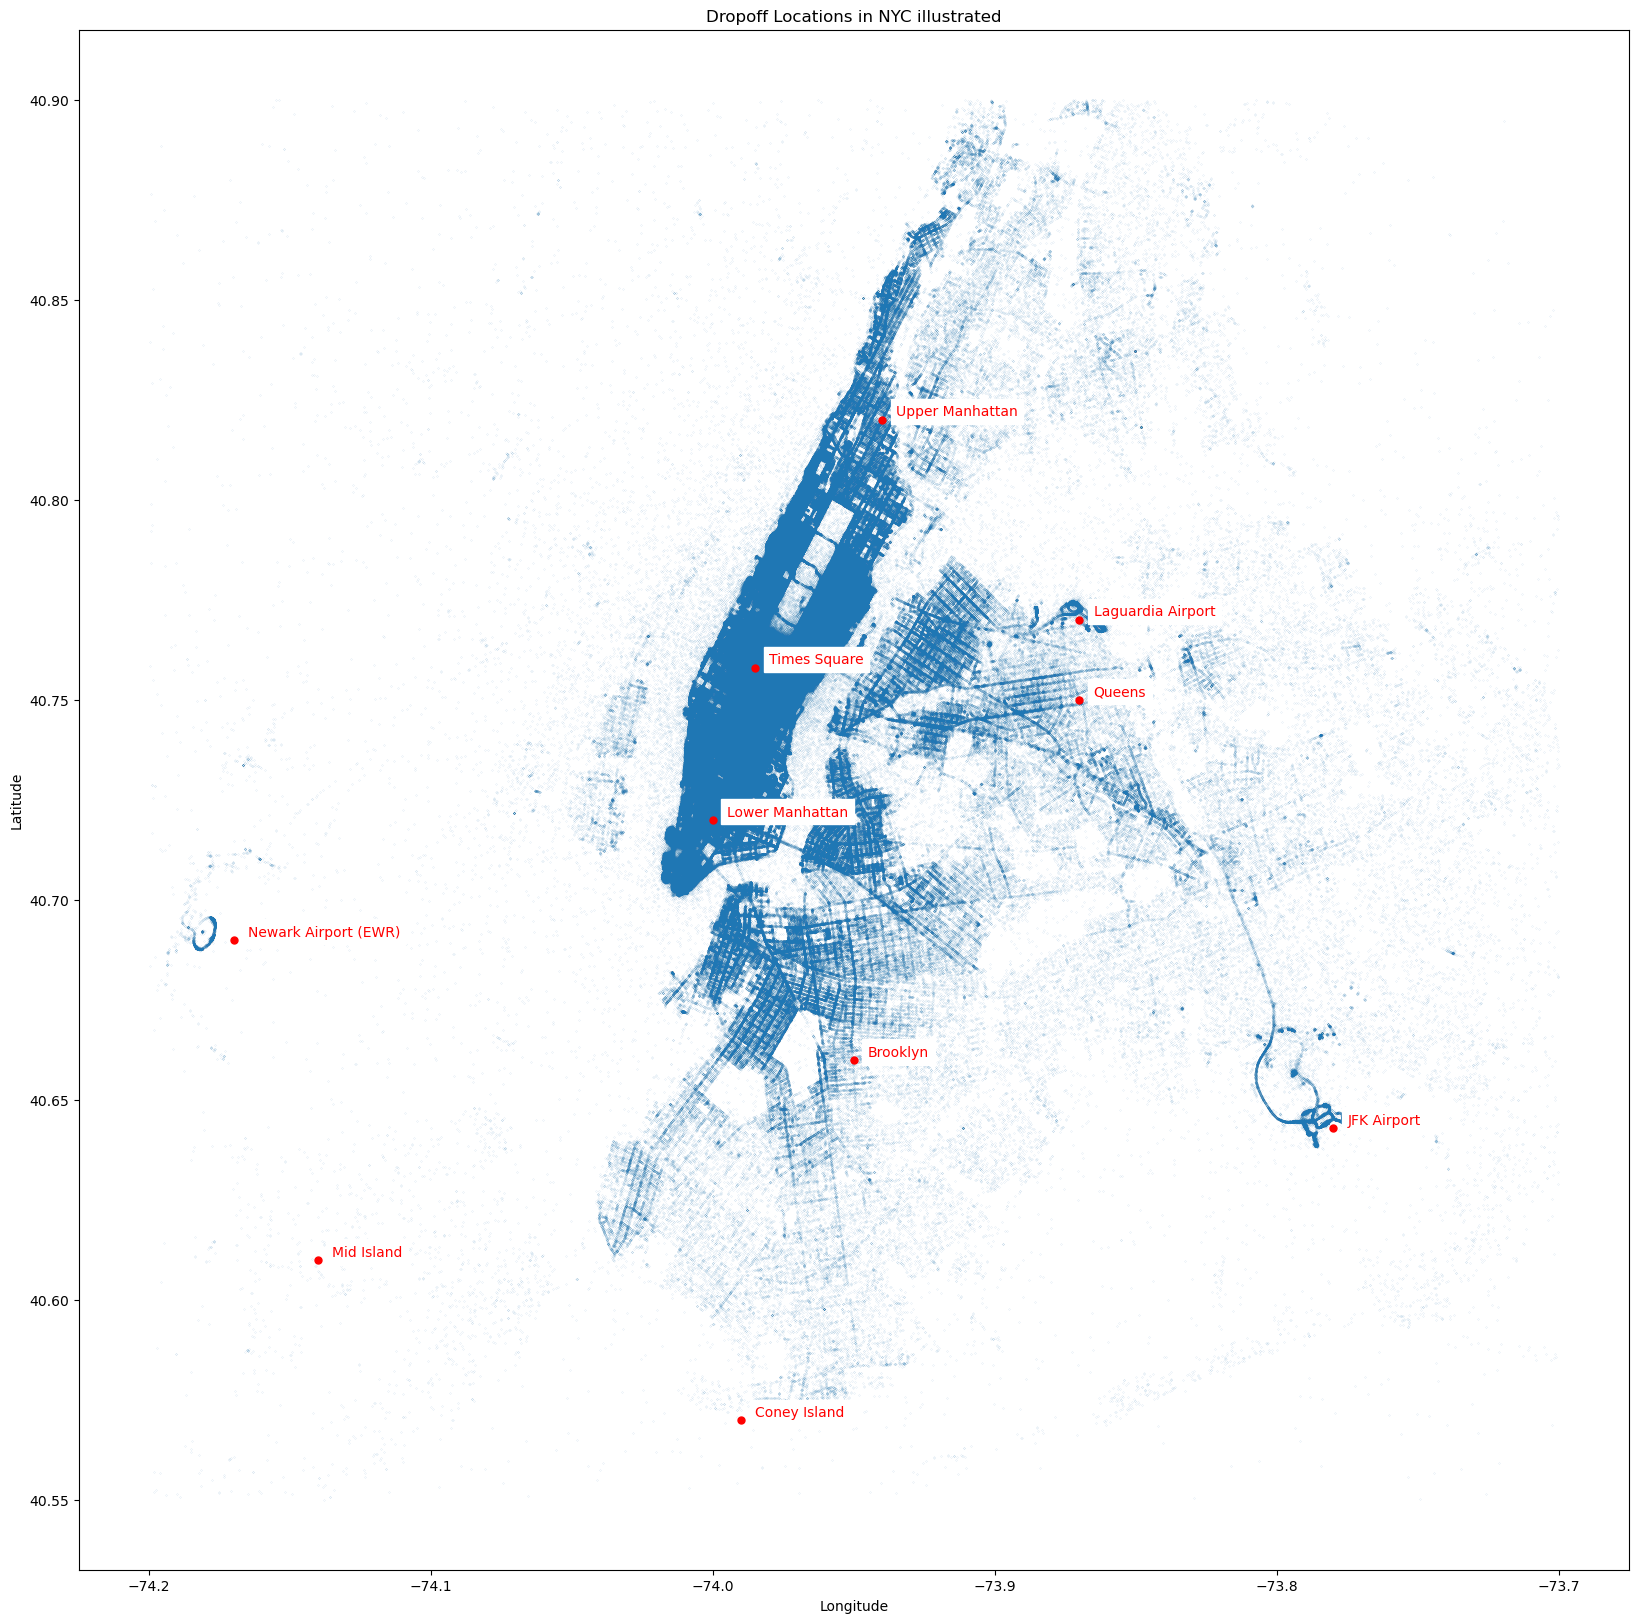

In [9]:
plt.figure(figsize = (20,20))
plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude),'.', markersize=0.1)

for landmark in landmarks:
    plt.plot(landmarks[landmark][0], landmarks[landmark][1],'.', markersize=10, alpha=1, color='r') 
    plt.annotate(landmark, (landmarks[landmark][0]+0.005, landmarks[landmark][1]+0.001), color='r', backgroundcolor='w')

plt.title("Dropoff Locations in NYC illustrated")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<div align="center">Looks very nice! it can be seen that the main volume of orders is concentrated in Manhattan, part of Brooklyn and airports.

#### Max fare amount
Let see the following histogram of **Fare amount**:

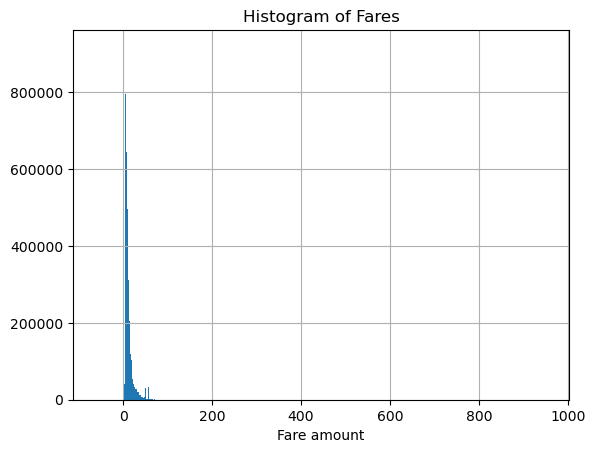

In [10]:
df['fare_amount'].hist(bins=700)
plt.xlabel("Fare amount")
plt.title("Histogram of Fares")
plt.show()

We will take only **positive** trip costs and limit the maximum cost to **$70** to eliminate possible outliers:

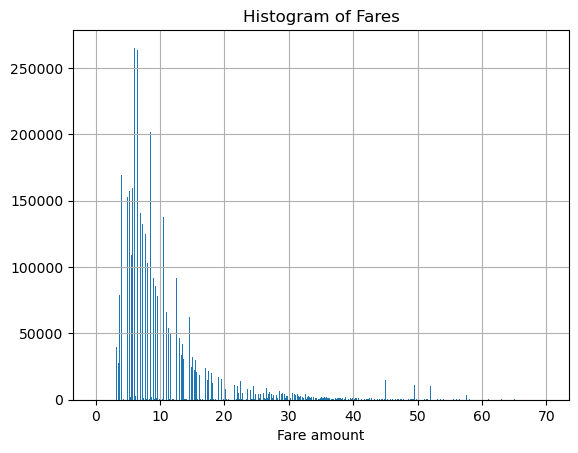

In [11]:
df = df[(df['fare_amount'] >=0) & (df['fare_amount'] <= 70)]

df['fare_amount'].hist(bins=700)
plt.xlabel("Fare amount")
plt.title("Histogram of Fares")
plt.show()

Looks good. We see small spikes in the range from 40 to 60 dollars - these can be fixed rates of different years, to test this hypothesis, we visit the ny taxi [website](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page) and find support for this hypothesis:

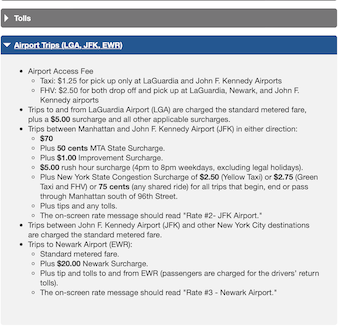

We see that there are fixed fares to airports JFK and EWR. Add a sign of each airport by selecting them by their coordinates:

In [12]:
import warnings
warnings.filterwarnings("ignore")

df['JFK'] = 0
df['EWR'] = 0

# longitude for JFK
JFK_min_longitude = -73.8
JFK_max_longitude = -73.75

# longitude for EWR
EWR_min_longitude = -74.2
EWR_max_longitude = -74.15

# latitude for LFK
JFK_min_latitude = 40.63
JFK_max_latitude = 40.65

# latitude for EWR
EWR_min_latitude = 40.67
EWR_max_latitude = 40.7

df['JFK'].loc[(df['pickup_longitude'] > JFK_min_longitude) & 
          (df['pickup_longitude'] < JFK_max_longitude) & 
          (df['pickup_latitude'] > JFK_min_latitude) &
          (df['pickup_latitude'] < JFK_max_latitude)] = 1

df['JFK'].loc[(df['dropoff_longitude'] > JFK_min_longitude) & 
          (df['dropoff_longitude'] < JFK_max_longitude) & 
          (df['dropoff_latitude'] > JFK_min_latitude) &
          (df['dropoff_latitude'] < JFK_max_latitude)] = 1

df['EWR'].loc[(df['pickup_longitude'] > EWR_min_longitude) & 
          (df['pickup_longitude'] < EWR_max_longitude) & 
          (df['pickup_latitude'] > EWR_min_latitude) &
          (df['pickup_latitude'] < EWR_max_latitude)] = 1

df['EWR'].loc[(df['dropoff_longitude'] > EWR_min_longitude) & 
          (df['dropoff_longitude'] < EWR_max_longitude) & 
          (df['dropoff_latitude'] > EWR_min_latitude) &
          (df['dropoff_latitude'] < EWR_max_latitude)] = 1

#### Number of passengers
Let's plot a histogram of **Passenger Count** to look at its distribution:

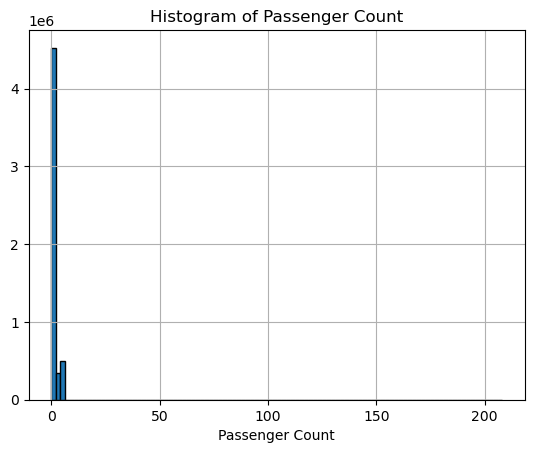

In [13]:
df['passenger_count'].hist(bins=100, ec='black')
plt.xlabel("Passenger Count")
plt.title("Histogram of Passenger Count")
plt.show()

We will take only non-zero numbers of passengers (replace 0 by 1) and maximum count is 10:

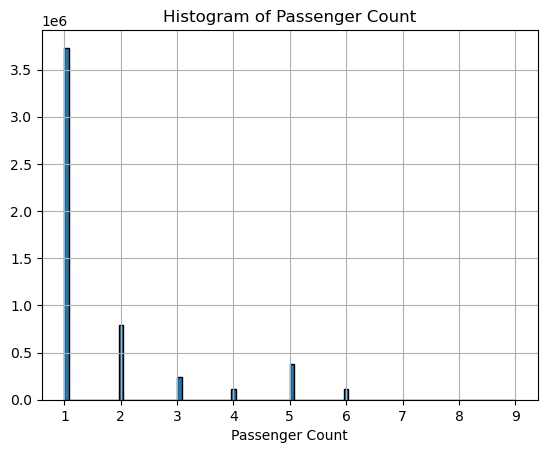

In [14]:
df.loc[df['passenger_count']==0, 'passenger_count'] = 1
df = df[df['passenger_count'] <10]

df['passenger_count'].hist(bins=100, ec='black')
plt.xlabel("Passenger Count")
plt.title("Histogram of Passenger Count")
plt.show()

Let's do a check to see whether there are any missing values in our dataset:

In [15]:
print(df.isnull().sum())

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
JFK                  0
EWR                  0
dtype: int64


Great! Now let's add a new column - the **distance travelled**.\
We will calculate the distance as the sum of two sides in a right triangle:

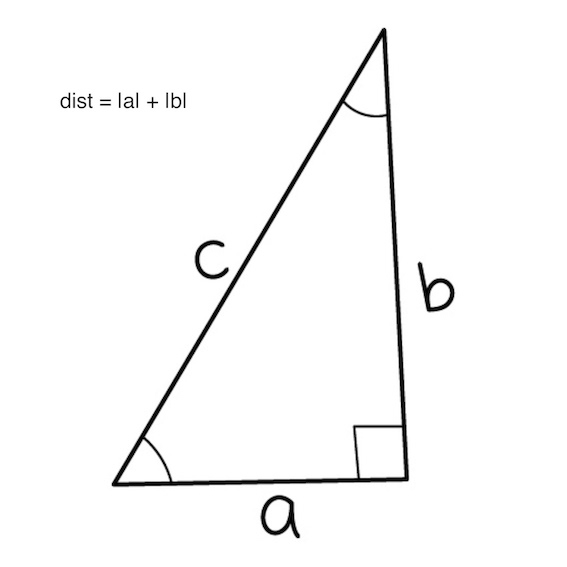

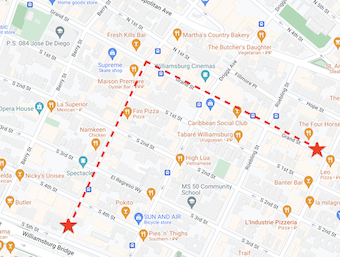

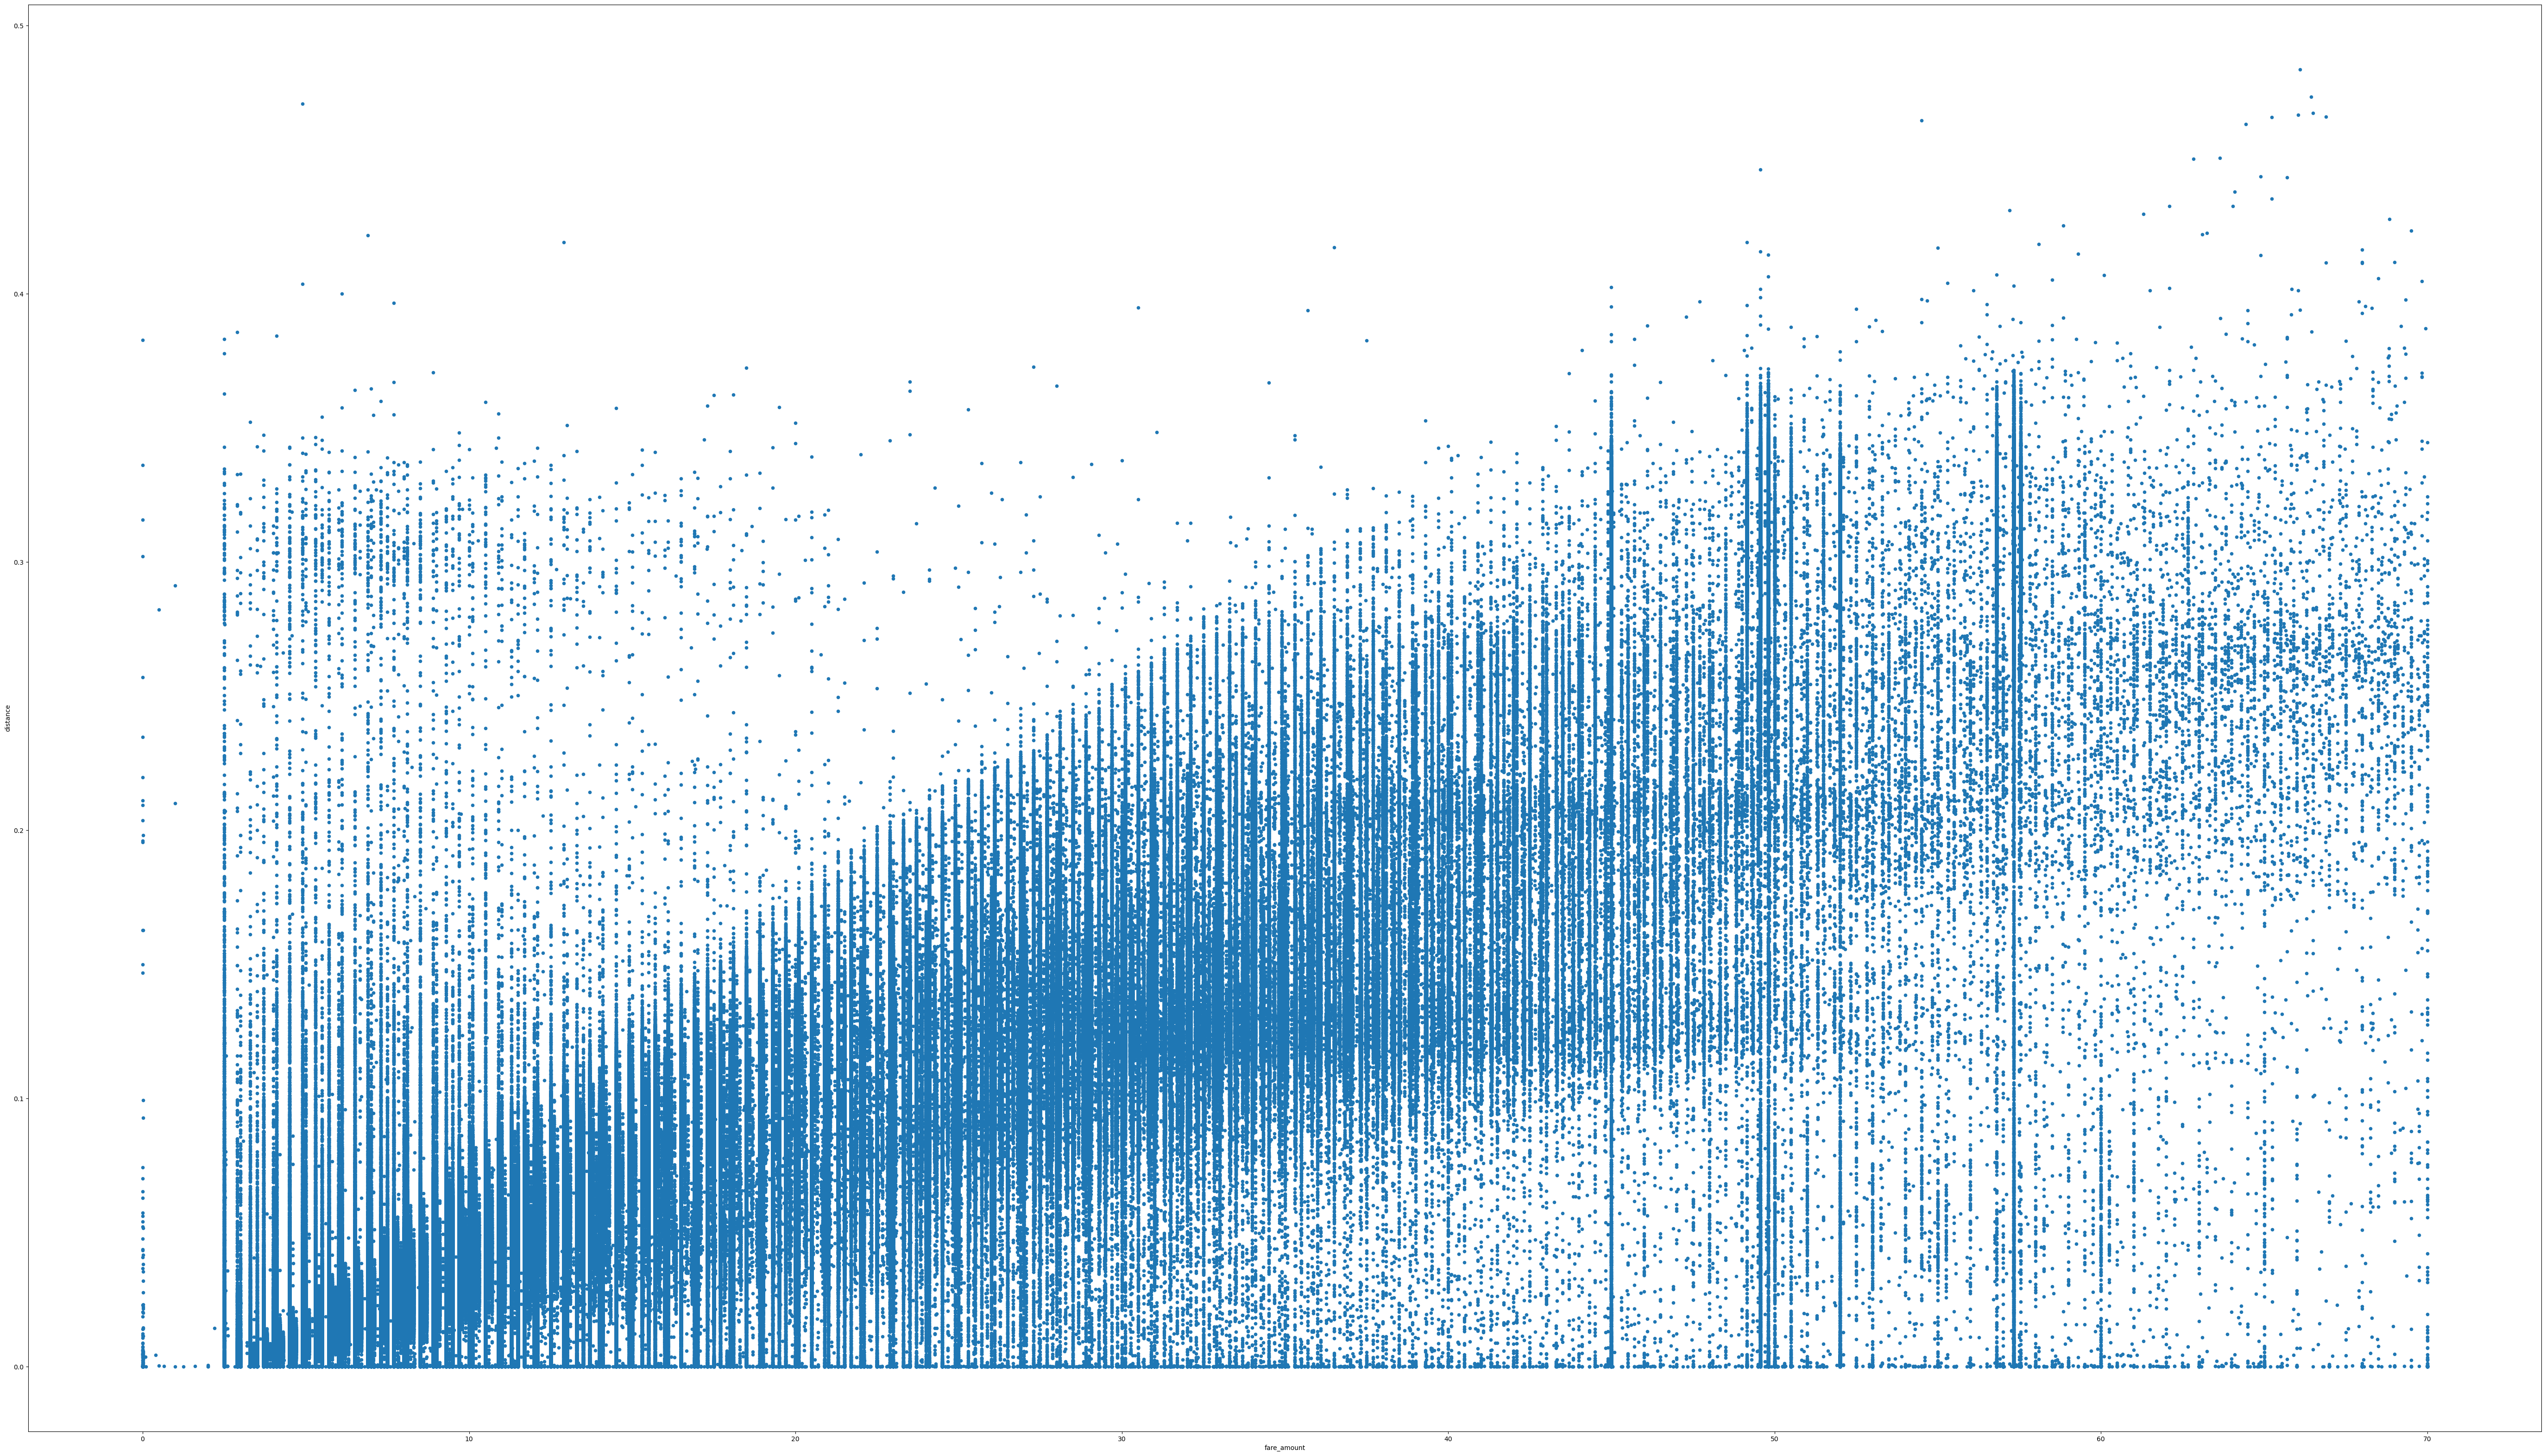

In [16]:
def distance(lat1, long1, lat2, long2):
    return(abs(lat1-lat2) + abs(long1-long2))

df['distance'] = distance(df['pickup_latitude'],
                              df['pickup_longitude'], 
                              df['dropoff_latitude'],
                              df['dropoff_longitude'])

df.plot.scatter('fare_amount', 'distance',figsize=(70, 40))
plt.show()

Strips between 40 and 60 dollars are clearly visible - these are fixed fares the same as to Histogram of Fares.
    
In general, everything is quite logical and uncontroversial: the greater the distance, the higher the price.

Let's separate the 'pickup_datetime' column into different columns for **'year'**, **'month'**, **'day'**, **'day_of_week'**, and **'hour'** and drop 'pickup_datetime':

In [17]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

df = df.drop(['pickup_datetime'], axis=1)

As a final preprocessing step, we should also scale our features before passing them to the neural network. We should also drop the fare_amount target variable before scaling, as we do not want to modify the target variable and columns **'JFK'**, **'EWR'** wich taking values 0 and 1:

In [18]:
from sklearn.preprocessing import scale

df_prescaled = df.copy()

df_scaled = df.drop(['fare_amount','JFK','EWR'], axis=1)
cols = df_scaled.columns.tolist()
df_scaled = scale(df_scaled)

Finally, convert the object returned by the scale function into a pandas DataFrame and concatenate the original columns that was dropped before scaling:

In [19]:
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
df_scaled = pd.concat([df_scaled, df[['fare_amount','JFK','EWR']]], axis=1)
df = df_scaled.copy()

For this project, we will be using a deep model. The deep feedforward network will have four hidden layers. The first hidden layer will have **128 nodes**, with each successive hidden layer having half the nodes of its predecessor. This neural network size is a good starting point for us, and it won't take long to train this neural network.

Between each hidden layer, we will use the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function to introduce non-linearity into the model. Because this is a regression problem, there will only be one node in the output layer. Note that we do not apply the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function to the output layer as this would change our predictions.

The following diagram illustrates the architecture of a feedforward deep neural network model (Figure from book "Neural Network Projects with Python" by James Loy):

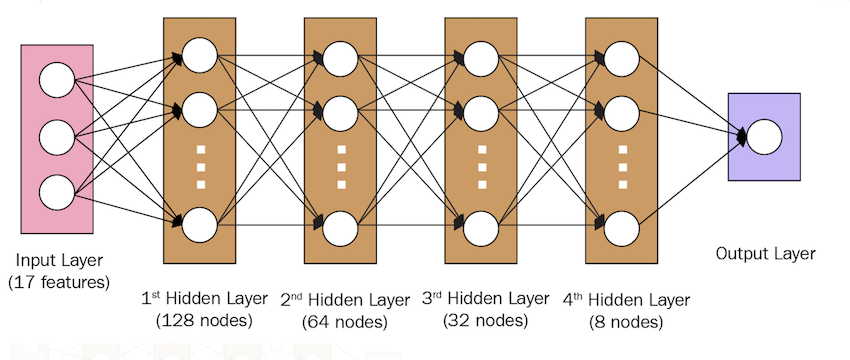

Now we are split the DataFrame into the training features (X) and the target variable that we're trying to predict (y):

In [20]:
X = df.loc[:, df.columns != 'fare_amount']
y = df.loc[:, 'fare_amount']

Split the data into a training set (**80%**) and a testing set (**20%**):

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Next, let's build our neural network architecture:

In [22]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation= 'relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(8, activation= 'relu'))
model.add(Dense(1))

 Now we verify the structure of our model:

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 12,401
Trainable params: 12,401
Non-trainable params: 0
_________________________________________________________________


Finally, we compile and train our neural network:

In [24]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, epochs=1)

134213/134213 [==============================] - 392s 3ms/step - loss: 11.6298 - mse: 11.6298


Let's conclude the results by calculating the **RMSE** for the entire training and testing set:

In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Train RMSE: {:0.2f}".format(train_rmse))
print("Test RMSE: {:0.2f}".format(test_rmse))

33554/33554 [==============================] - 69s 2ms/step
Train RMSE: 3.28
Test RMSE: 3.31


<div align="center">Looks sooo good! We designed a deep feedforward neural network capable of predicting taxi fares in NYC within an error of ~$3.28!